In [52]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sqlalchemy.orm import sessionmaker, aliased
from sqlalchemy import create_engine, func
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython import display

from data.models import Player, GameStats, KtcValue
load_dotenv()

True

In [5]:
DB_USERNAME = os.environ['DB_USERNAME']
DB_PASSWORD = os.environ['DB_PASSWORD']
DB_HOST = os.environ['DB_HOST']
DB_PORT = os.environ['DB_PORT']
DB_NAME = os.environ['DB_NAME']

DB_URL = f"postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

engine = create_engine(DB_URL, echo=False)
Session = sessionmaker(bind=engine)
session = Session()

Features
    -POS
    -Season
    -YOE
    -Age
    -Height
    -Weight
    -Draft Pick
    -Season Avg Pts Above POS# 
    -Game Avg Pts per Game
    -Current Team
    -Current Team's previous record
    Seaonal
        -Pts Above POS#
        -Pts High Pts
        -Pts Low Pts
        -Pts Average
        -Pts Total
        -Consistency (Pts STD)
        -Team
        -Team Record
        -Games Played
        -Games Missed due to Injury
        -Previous Season Delta (for non rookies)
    Positional
        QB
            -Passing Yards
            -Passing TDs
            -Attemps
            -Completions
            -Interception
            -Rushing Yards
            -Rushing TDs
            -Passing EPA
            -Rushing EPA
        RB
            -Attemps
            -Rushing Yards
            -Rushing TDs
            -Receptions
            -Receiving TDs
            -Rushing EPA
            -Recieving EPA
        WR
            -Targets
            -Receptions
            -Recieving Yards
            -Recieving TDs
            -Recieving EPA
            -Target Share
        TE
            -Targets
            -Receptions
            -Recieving Yards
            -Recieving TDs
            -Recieving EPA
            -Target Share

In [6]:

def get_player_game_data(session):
    # Subquery to get the most recent KtcValue for each player
    latest_ktc = session.query(
        KtcValue.player_id,
        func.max(KtcValue.date).label('latest_ktc_date')
    ).group_by(KtcValue.player_id).subquery()

    query = (
        session.query(
            Player.id,
            Player.position,
            Player.height,
            Player.weight,
            Player.yoe,
            Player.draft_number,
            Player.team_abbr,
            Player.birth_date,
            GameStats.season,
            GameStats.week,
            GameStats.fantasy_points_ppr,
            GameStats.completions,
            GameStats.attempts,
            GameStats.passing_yards,
            GameStats.passing_tds,
            GameStats.passing_epa,
            GameStats.interceptions,
            GameStats.rushing_epa,
            GameStats.rushing_yards,
            GameStats.rushing_tds,
            GameStats.receptions,
            GameStats.targets,
            GameStats.receiving_epa,
            GameStats.receiving_yards,
            GameStats.receiving_tds,
            latest_ktc.c.latest_ktc_date
        )
        .join(GameStats, Player.id == GameStats.player_id)
        .outerjoin(latest_ktc, Player.id == latest_ktc.c.player_id)
    )

    return pd.read_sql(query.statement, session.bind)

# Usage
player_data = get_player_game_data(session)

In [7]:
player_data = get_player_game_data(session)
player_data['latest_ktc_date'] = pd.to_datetime(player_data['latest_ktc_date'])

# Get current date
current_date = datetime.now()

# Calculate days since last KtcValue
player_data['days_since_last_ktc'] = (current_date - player_data['latest_ktc_date']).dt.days

# Print some statistics
print(f"Total number of game records: {len(player_data)}")
print(f"Number of unique players: {player_data['id'].nunique()}")
print(f"Number of players with KtcValue: {player_data['latest_ktc_date'].notna().sum()}")
print(f"Number of players without KtcValue: {player_data['latest_ktc_date'].isna().sum()}")

# Let's see the distribution of days since last KtcValue
print(player_data['days_since_last_ktc'].describe())

# Let's count how many players would be considered "retired" for different thresholds
for threshold in [7, 30, 90, 180, 365]:
    retired_count = ((player_data['days_since_last_ktc'] > threshold) | player_data['latest_ktc_date'].isna()).sum()
    print(f"Players 'retired' (no KtcValue in last {threshold} days): {retired_count}")

# Get the most recent season for each player
player_data['most_recent_season'] = player_data.groupby('id')['season'].transform('max')

# Consider a player retired if they don't have a KtcValue and their most recent season is not the current season
current_season = player_data['season'].max()
player_data['is_retired'] = (player_data['latest_ktc_date'].isna()) & (player_data['most_recent_season'] < current_season)

print(f"Number of 'retired' players (no KtcValue and not in current season): {player_data['is_retired'].sum()}")

Total number of game records: 129738
Number of unique players: 4020
Number of players with KtcValue: 31235
Number of players without KtcValue: 98503
count    31235.000000
mean         3.125980
std         13.387979
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         61.000000
Name: days_since_last_ktc, dtype: float64
Players 'retired' (no KtcValue in last 7 days): 100118
Players 'retired' (no KtcValue in last 30 days): 100118
Players 'retired' (no KtcValue in last 90 days): 98503
Players 'retired' (no KtcValue in last 180 days): 98503
Players 'retired' (no KtcValue in last 365 days): 98503
Number of 'retired' players (no KtcValue and not in current season): 94885


In [32]:
def process_season_data(df: pd.DataFrame):
    # Your existing aggregation code here
    season_data = df.groupby(['id', 'season']).agg({
        'is_retired': 'first',
        'position': 'first',
        'height': 'first',
        'weight': 'first',
        'yoe': 'first',
        'draft_number': 'first',
        'team_abbr': 'first',
        'birth_date': 'first', 
        'fantasy_points_ppr': ['mean', 'max', 'min', 'std', 'sum', 'count'],

        'completions': 'sum',
        'attempts': 'sum',
        'passing_yards': 'sum',
        'passing_tds': 'sum',
        'passing_epa': 'sum',
        'interceptions': 'sum',

        'rushing_yards': 'sum',
        'rushing_tds': 'sum',
        'rushing_epa': 'sum',

        'receptions': 'sum',
        'targets': 'sum',
        'receiving_yards': 'sum',
        'receiving_tds': 'sum',
        'receiving_epa': 'sum',
    })

    season_data.columns = ['_'.join(col).strip() for col in season_data.columns.values]
    season_data = season_data.rename(columns={
        'position_first': 'position',  # Rename the position column
        'fantasy_points_ppr_mean': 'avg_fantasy_points',
        'fantasy_points_ppr_max': 'max_fantasy_points',
        'fantasy_points_ppr_min': 'min_fantasy_points',
        'fantasy_points_ppr_std': 'std_fantasy_points',
        'fantasy_points_ppr_sum': 'total_fantasy_points',
        'fantasy_points_ppr_count': 'games_played',
        'birth_date_first': 'birth_date'
    })

    season_data = season_data.reset_index()

    def calculate_age(birth_date, season):
        if pd.isnull(birth_date):
            return None
        birth_year = birth_date.year
        return season - birth_year
    
    season_data['age'] = season_data.apply(lambda row: calculate_age(row['birth_date'], row['season']), axis=1)

    # Filter out None values when calculating median
    valid_position_data = season_data[season_data['position'].notna()]
    median_std_by_position = valid_position_data.groupby('position')['std_fantasy_points'].median()

    # Calculate overall median to use as default
    overall_median_std = valid_position_data['std_fantasy_points'].median()

    # Apply median std_fantasy_points for missing values
    for position in season_data['position'].unique():
        if pd.isna(position):
            position_mask = season_data['position'].isna() & season_data['std_fantasy_points'].isna()
            season_data.loc[position_mask, 'std_fantasy_points'] = overall_median_std
        else:
            position_mask = (season_data['std_fantasy_points'].isna()) & (season_data['position'] == position)
            season_data.loc[position_mask, 'std_fantasy_points'] = median_std_by_position.get(position, overall_median_std)

    # Handle missing ages
    players_missing_age = season_data[season_data['age'].isna()]['id'].unique()
    for player_id in players_missing_age:
        player_data = season_data[season_data['id'] == player_id].sort_values('season')
        first_season = player_data['season'].iloc[0]
        player_data['age'] = player_data['season'] - first_season + 22
        season_data.loc[season_data['id'] == player_id, 'age'] = player_data['age']

    # Round age to nearest integer
    season_data['age'] = season_data['age'].round().astype('Int64')

    return season_data



In [33]:
season_data = process_season_data(player_data)

In [34]:
def calculate_vorp(df):
    # Filter for only QB, WR, RB, TE positions
    valid_positions = ['QB', 'WR', 'RB', 'TE']
    df = df[df['position'].isin(valid_positions)].copy()

    # Define the replacement level for each position
    replacement_levels = {
        'QB': 32,
        'RB': 36,
        'WR': 36,
        'TE': 16,
    }
    
    # Function to get the nth highest score for a position in a season
    def get_nth_score(group, n):
        return group.nlargest(n, 'total_fantasy_points').iloc[-1]['total_fantasy_points']
    
    # Calculate the replacement level score for each position in each season
    for position, n in replacement_levels.items():
        position_mask = df['position'] == position
        if position_mask.any():
            df[f'{position}_replacement'] = df[position_mask].groupby('season').apply(lambda x: get_nth_score(x, n))
            df[f'{position}_replacement'] = df.groupby('season')[f'{position}_replacement'].transform('first')
    
    # Calculate VORP
    def calculate_player_vorp(row):
        replacement_col = f"{row['position']}_replacement"
        if replacement_col in df.columns:
            return row['total_fantasy_points'] - row[replacement_col]
        else:
            return 0  # This shouldn't happen now, but keep it as a safeguard

    df['vorp'] = df.apply(calculate_player_vorp, axis=1)
    
    return df

season_data_with_vorp = calculate_vorp(season_data)


In [35]:
def create_cumulative_stats(df: pd.DataFrame):
    df = df.sort_values(['id', 'season'])
    
    cumulative_cols = ['total_fantasy_points', 'completions_sum', 'attempts_sum', 'passing_yards_sum', 
                       'passing_tds_sum', 'interceptions_sum', 'rushing_yards_sum', 'rushing_tds_sum', 
                       'receptions_sum', 'targets_sum', 'receiving_yards_sum', 'receiving_tds_sum']
    
    for col in cumulative_cols:
        df[f'cumulative_{col}'] = df.groupby('id')[col].cumsum()
    
    df['career_length'] = df.groupby('id').cumcount() + 1
    
    return df



In [36]:
cumulative_season_data = create_cumulative_stats(season_data_with_vorp)

In [43]:
def add_career_totals(df):
    # Identify cumulative columns
    cumulative_cols = [col for col in df.columns if col.startswith('cumulative_')]
    
    # Get the final career stats for each player
    final_stats = df.groupby('id').last()
    
    # Rename columns to indicate these are career totals
    career_total_cols = [col.replace('cumulative_', '') + '_career_total' for col in cumulative_cols]
    final_stats = final_stats.rename(columns=dict(zip(cumulative_cols, career_total_cols)))
    
    # Merge these back to the main dataframe
    df = df.merge(final_stats[career_total_cols], on='id')
    
    # Add total career length
    df['total_career_length'] = df.groupby('id')['career_length'].transform('max')
    
    return df

final_data = add_career_totals(cumulative_season_data)

In [44]:
def calculate_remaining_vorp(df):
    # Sort the dataframe by player ID and season
    df = df.sort_values(['id', 'season'])
    
    # Calculate total career VORP for each player
    total_career_vorp = df.groupby('id')['vorp'].sum()
    
    # Calculate cumulative VORP up to each season
    df['cumulative_vorp'] = df.groupby('id')['vorp'].cumsum()
    
    # Merge total career VORP back to the dataframe
    df = df.merge(total_career_vorp.rename('total_career_vorp'), on='id')
    
    # Calculate remaining career VORP
    df['remaining_career_vorp'] = df['total_career_vorp'] - df['cumulative_vorp']
    
    # Fill any remaining NaN values with 0
    df[['vorp', 'cumulative_vorp', 'total_career_vorp', 'remaining_career_vorp']] = df[['vorp', 'cumulative_vorp', 'total_career_vorp', 'remaining_career_vorp']].fillna(0)
    
    return df

# Apply this function to your dataframe
final_data = calculate_remaining_vorp(final_data)

In [46]:
final_data['draft_number_first'] = final_data['draft_number_first'].fillna(300)
final_data.dropna(subset=['yoe_first'], inplace=True)
final_data = final_data[final_data['is_retired_first']]
has_nan = final_data.isna().sum()
for column, count in has_nan.items():
    if count != 0:
        print(f'{column}: {count}')

birth_date: 6193
QB_replacement: 3306
RB_replacement: 3306
WR_replacement: 3306
TE_replacement: 3306


In [47]:
final_data.shape

(9877, 65)

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [62]:
feature_cols = [
    'season', 'yoe_first', 'age', 
   # 'height_first', 'weight_first',
    'draft_number_first', 
    'vorp', 
    'avg_fantasy_points',
    #'max_fantasy_points', 
    #'min_fantasy_points', 
    'std_fantasy_points',
    'total_fantasy_points', 
    'games_played',
    #position
    'cumulative_total_fantasy_points', 
    'cumulative_completions_sum',
    'cumulative_attempts_sum', 
    'cumulative_passing_yards_sum',
    'cumulative_passing_tds_sum', 
    'cumulative_interceptions_sum',
    'cumulative_rushing_yards_sum', 
    'cumulative_rushing_tds_sum',
    'cumulative_receptions_sum', 
    'cumulative_targets_sum',
    'cumulative_receiving_yards_sum', 
    'cumulative_receiving_tds_sum',

    'completions_sum', 
    'attempts_sum', 
    'passing_yards_sum',
    'passing_tds_sum', 
    'passing_epa_sum',
    'interceptions_sum',
    'rushing_yards_sum',
    'rushing_tds_sum', 
    'rushing_epa_sum',
    'receptions_sum', 
    'targets_sum', 
    'receiving_yards_sum',
    'receiving_tds_sum', 
    'receiving_epa_sum'
]

class PlayerCareerDataset(Dataset):
    def __init__(self, data, sequence_length=5):
        self.data = data
        self.sequence_length = sequence_length
        
        self.feature_cols = feature_cols
        self.target_col = 'remaining_career_vorp'       
        
        # Normalize features
        self.scaler = StandardScaler()
        self.data[self.feature_cols] = self.scaler.fit_transform(self.data[self.feature_cols])
        
        # Group by player
        self.grouped = list(self.data.groupby('id'))

    def __len__(self):
        return len(self.grouped)

    def __getitem__(self, idx):
        _, player_data = self.grouped[idx]
        
        # Pad sequences shorter than sequence_length
        if len(player_data) < self.sequence_length:
            pad_length = self.sequence_length - len(player_data)
            pad = pd.DataFrame(0, index=range(pad_length), columns=player_data.columns)
            player_data = pd.concat([pad, player_data]).reset_index(drop=True)
        
        # Get features and target
        features = player_data[self.feature_cols].values[-self.sequence_length:]
        target = player_data[self.target_col].values[-1]  # Use the last value as target
        
        return torch.FloatTensor(features), torch.FloatTensor([target])

# Split data into train and test sets
train_data, test_data = train_test_split(final_data, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = PlayerCareerDataset(train_data)
test_dataset = PlayerCareerDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.bn(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Initialize the model
input_size = len(train_dataset.feature_cols)
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)

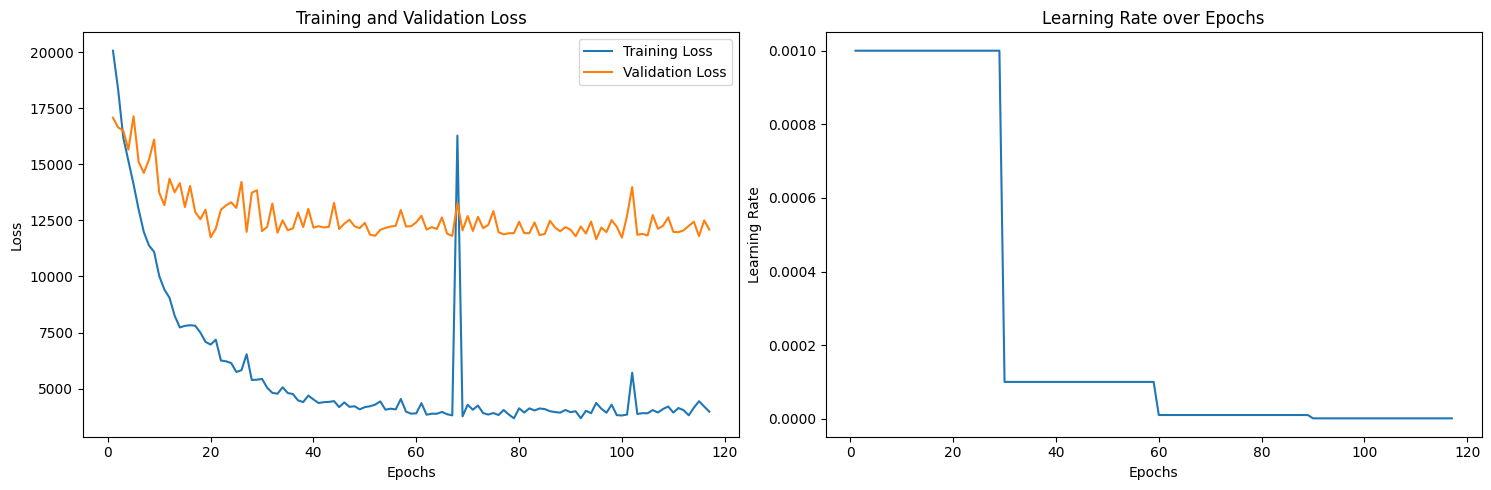

Epoch [117/200], Train Loss: 3972.6135, Val Loss: 12087.6037


KeyboardInterrupt: 

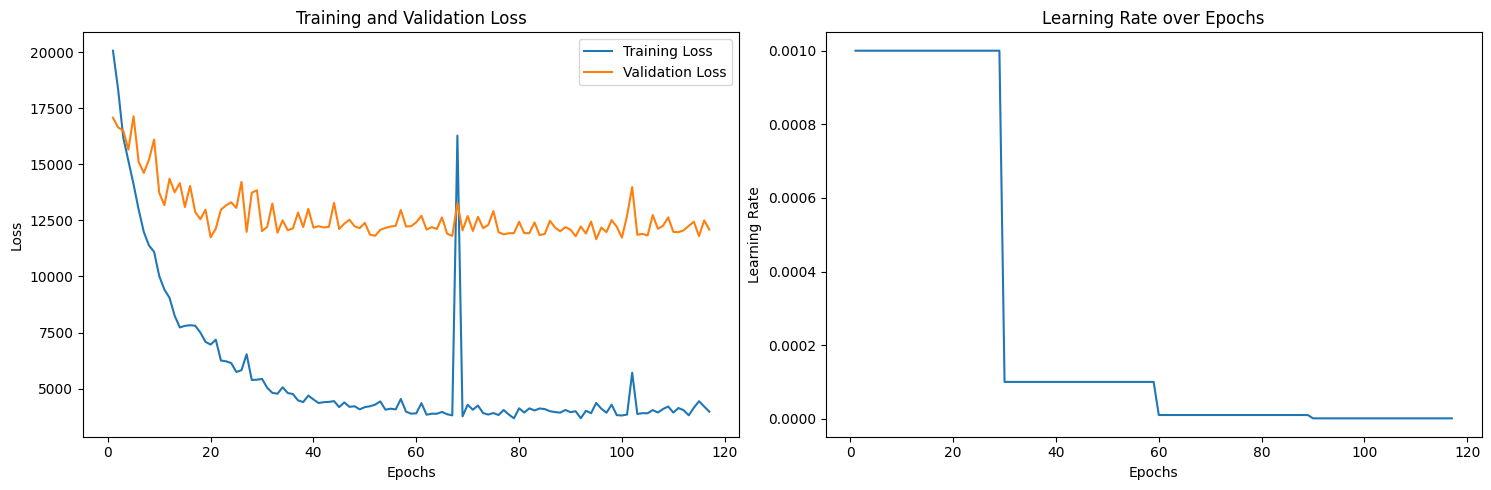

In [64]:
# Set up the plot
plt.ion()  # Turn on interactive mode

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
train_line, = ax1.plot([], [], label='Training Loss')
val_line, = ax1.plot([], [], label='Validation Loss')
lr_line, = ax2.plot([], [])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate over Epochs')

plt.tight_layout()

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
learning_rates = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step()
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            outputs = model(batch_features)
            val_loss += criterion(outputs, batch_targets).item()
    
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Update the plot
    if len(train_losses) > 1:
        epochs = list(range(1, epoch + 2))
        
        train_line.set_data(epochs, train_losses)
        val_line.set_data(epochs, val_losses)
        lr_line.set_data(epochs, learning_rates)
        
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

plt.ioff()  # Turn off interactive mode
plt.show()

In [48]:
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():  # No need to track gradients for inference
    for batch_features, batch_targets in test_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        outputs = model(batch_features)
        
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(batch_targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate MSE for the entire test set
mse = np.mean((all_predictions - all_targets) ** 2)
print(f'Test MSE: {mse:.4f}')

Test MSE: 23162.0234
